In [1]:
%matplotlib inline
from IPython.display import display, Image, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import os

# A forcefield parametrization of NaSCN and KSCN

In this Jupyter Notebook the development of a thermodynamically sound forcefield for aqueous NaSCN and KSCN is presented. The adjustable model parameters are the ones appearing in the Lennard-Jones (LJ) potential, $\sigma_{ij}$ and $\epsilon{ij}$, describing the potential energy of interaction between two atoms $i$ and $j$:

\begin{equation}
V_{LJ}(r_{ij})=4\varepsilon_{ij} \left [\left (\frac {\sigma_{ij}} {r_{ij}} \right )^{12} - \left (\frac {\sigma_{ij}} {r_{ij}} \right )^{6} \right ]
\end{equation}

Here, $\sigma_{ij}$ is the LJ diameter and $\varepsilon_{ij}$ is the LJ interaction strength between the two atoms.

<img src="figs/lennard-jones_potential.png",width=400>

In the next two cells we will plot the equation describing the LJ-potential between atoms $i$ and $j$. The plot is interactive, meaning that the user can change the two investigated variables ($\sigma_{ij}$ and $\epsilon_{ij}$) using sliders to see how the LJ-potential changes. 

In [2]:
# Defining the function that described the LJ-potential

def plot_LJ(eps, sig):
    r = np.linspace(0.1,10,100)
    V_LJ = 4*eps*((sig/r)**12 - (sig/r)**6)
    plt.plot(r, V_LJ, lw=4, color='b')
    plt.ylim(-0.6, 1)
    plt.xlabel('$r$ (Å)')
    plt.ylabel('$V_{LJ, ij}$ (kJ/mol)')
    plt.show

In [3]:
# Setting up and plotting the interactive plot

from ipywidgets import interactive
interactive_plot = interactive(plot_LJ, eps=(0.2, 0.5, .01), sig=(2.0, 4.0, .1))
interactive_plot.children[0].description=r'$\varepsilon_{ij}$ (kJ/mol)' # slider 1
interactive_plot.children[1].description=r'$\sigma_{ij}$ (Å)'  # slider 2
interactive_plot

A Jupyter Widget

## Simulation parameters

The final obtained atomic parameters in this study are listed in the table below. 

|  Atom   | $q$/e      | $\sigma$/Å | $\varepsilon$/(kJ/mol)
|-------- | --------   | ---------- | ------------- 
|   O     | -0.8476    |   3.166    |   0.6502
|   H     | +0.4238    |   0        |   0
|   S     | -0.573     |   3.83     |   1.523
|   C     | +0.483     |   3.35     |   0.425
|   N     | -0.910     |   3.70     |   0.310
|   Na    | +1         |   2.55     |   0.280
|   K     | +1         |   4.03     |   0.850       

The values listed are the LJ parameters for the individual atomic species, which were inserted directly into the simulation protocol. These relates to the parameters appearing in the LJ-potential by two equations commonly known as the Lorentz-Berthelot combination rule:

\begin{align}
\sigma_{ij}=\frac {\sigma_{i}+\sigma_{j}}{2}; &&  \varepsilon_{ij}=\sqrt {\varepsilon_{i}\varepsilon_{j}}   
\tag{1a; 1b}
\end{align}

where $\sigma_{i}$ and $\sigma_{j}$ are the LJ diameters, while $\varepsilon_{i}$ and $\varepsilon_{i}$ are the LJ interaction strengths, for the single atoms $i$ and $j$, respectively. This part of the study only determined the LJ parameters for S, C, N, Na$^{+}$ and K$^{+}$, while the parameters for O and H were specified according to the SPCE water model. The partial charges of S, C and N in (SCN$^{-}$) were determined in another part of this study.

## Thermodynamic properties and experimental data

In order to evaulate the performance of the forcefield while tweaking the adjustable parameters some suitable property had to be calculated and compared with experiments. Here, the activity $a_{c}$ was chosen as the property to evaluate, since its derivative can be calculated using Kirkwood-Buff (KB) theory. More specifically, the following property was calculated from simulations and compared with experiments:

\begin{equation}
a_{c}' = \left (\frac{\partial \ln a_c}{\partial \ln \rho_c}\right )_{p,T}=\frac{1}{1+\rho_{c}(G_{cc}-G_{wc})}\\
=\frac{1}{1+\Delta N_{cc}-\Delta N_{wc}}
\tag{2}
\end{equation}

Here, $c$ denotes the electrolyte, for example NaSCN, where the model does not distinguish between cations and anions, in this case Na$^+$ and SCN$^-$, and $w$ denotes water. The KB integrals $G_{ij}$ are calculated by integrating the radial distribution function (RDF). In our example with electrolyte and water, they become

\begin{align}
G_{cc}(r)\approx 4{\pi}\int_{0}^{R}[g_{cc,sim}(r)-1]r^2dr; && G_{wc}(r)\approx 4{\pi}\int_{0}^{R}[g_{wc,sim}(r)-1]r^2dr  
\tag{3a; 3b}
\end{align}

where $r$ is a running coordinate from the center atom. The approximately equal signs are here applied since the theory is only exact when the system is of infinite size, which is not the case when performing molecular dynamics simulations. Two alternative ways to deal with this are presented later on. As a result, the integral has to be truncated as some distance $R$ from the center atom. The natural choice is the distance after which the solution bulk is reached, i.e., the concentration of for instance electrolyte around electrolyte does no longer change as we go further out from the center atom. 

The RDFs are obtained from simulations where they are computed as

\begin{align}
g_{cc,sim}(r) = \frac{\rho _{cc}(r)}{\rho_{c}}; && g_{wc,sim}(r) = \frac{\rho _{wc}(r)}{\rho_{c}}
\tag{4a; 4b}
\end{align}

where $\rho _{cc}(r)$ and $\rho _{wc}(r)$ are the concetrations of electrolyte at distance $r$ from the center atom which in the former is an electrolyte ion and in the latter the oxygen atom in a water molecule. The quantity $\rho_{c}$ is the average number density of the electrolyte in the simulation box. 

Finally, the excess coordination numbers $\Delta N_{cc}$ and $\Delta N_{wc}$ which physically mean the excess number of particles of electrolyte around electrolyte and electrolyte around water, respectively, compared to the concentration in the solution bulk, are calculated as

\begin{align}
\Delta N_{cc}(r)=\rho_{c}G_{cc}(r); && \Delta N_{wc}(r)=\rho_{c}G_{wc}(r)
\tag{5a; 5b}
\end{align}



## Loading the RDFs 

In the next cell we will load the RDFs generated from previously performed simulations.

In [4]:
def loadRDFs(cation,anion,waterModel,conc,subplot):
    
    """ This function loads and plot RDFs and takes five arguments:
    - cation: 'K' or 'Na'
    - anion: 'SCN'
    - waterModel: 'spce' or 'opc3'
    - conc - 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 (m)
    - subplot (i.e. where the subplot will appear)
    """
    
    
    WORKDIR = %pwd

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)


    index = 0 # Initializing concentration index                     
        
    wdir_exp_data = WORKDIR+'/data/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            
            
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
    subplot.plot(r,g_cc_avg, label="$g_{cc}(r)$", color='magenta')
    subplot.plot(r,g_wc_avg, label="$g_{wc}(r)$", color='blue')
    subplot.set_xlabel("$r/nm$", fontsize=25)
    subplot.set_ylabel("$g(r)$", fontsize=25)

## Plot loaded RDFs
Here, the RDFs are plotted for NaSCN and KSCN at all concentrations studied.

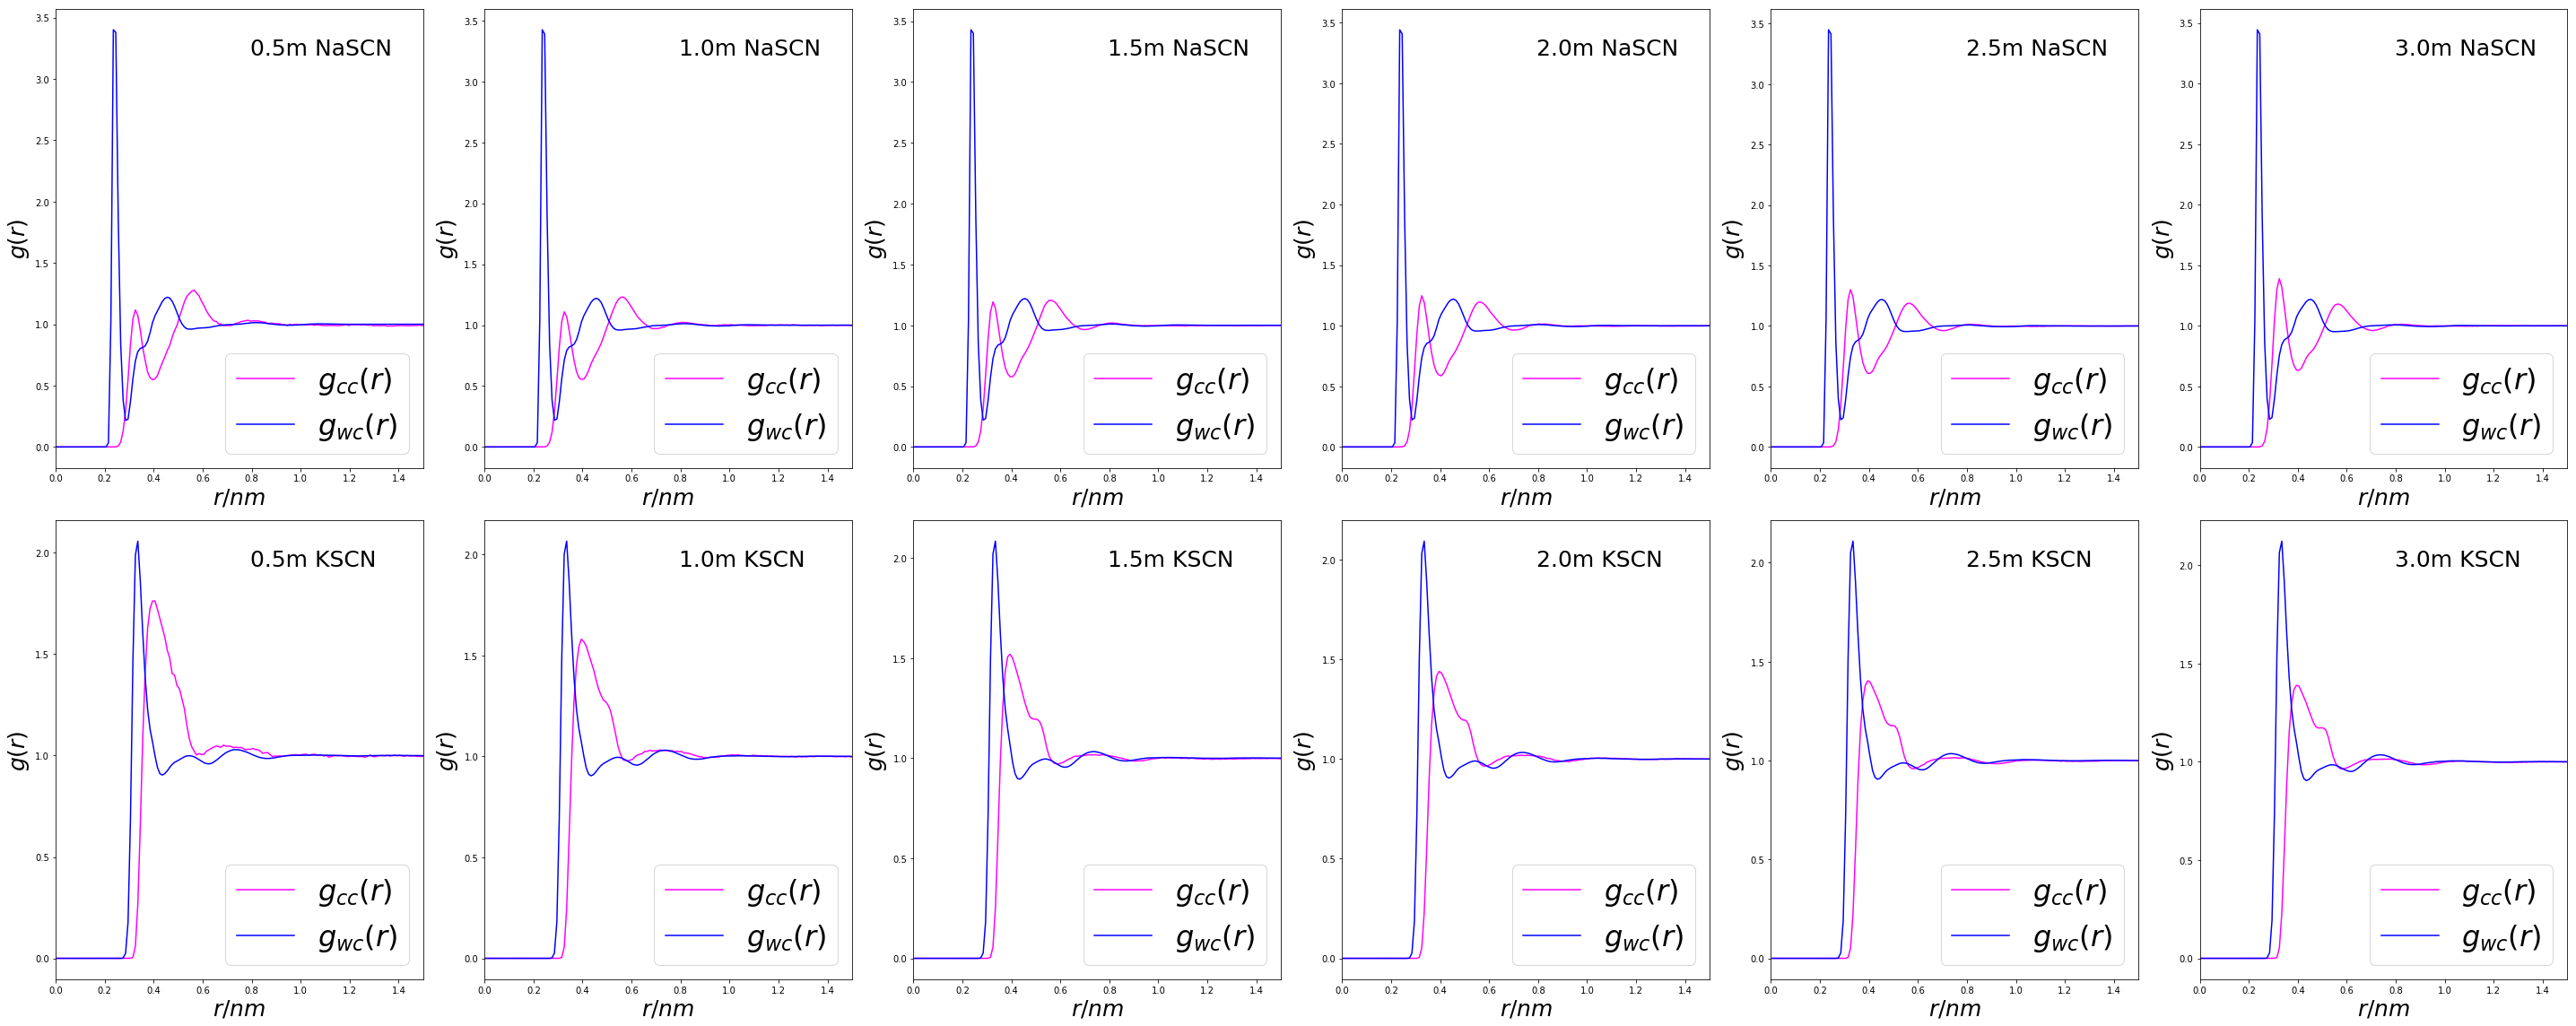

In [5]:
cations = ['Na', 'K']
anion = 'SCN'
concs = np.linspace(start=0.5, stop=3.0, num=6)

n_rows = len(cations)
n_cols = len(concs)


fig_dim = np.array((5, 2))*8
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        loadRDFs(cations[i],anion,'spce',concs[j],ax)
        ax.annotate(str(concs[j])+'m '+cations[i]+anion,xy=(0.53,.9), fontsize=25, xycoords='axes fraction')
        plt.xlim((0, 1.5))
        plt.legend(loc=4, fontsize=32)
        plt.tight_layout(w_pad=1,h_pad=1)

## Compute excess coordination numbers
Here, the method to calculate the excess coordination numbers, $N_{cc}(r)$ and $N_{cc}(r)$, is defined. The property that is plotted is denoted $\Gamma(r)$, and is defined as

\begin{align}
\Gamma(r) = N_{cc}(r) - N_{wc}(r)
\tag{6}
\end{align}

This property is later used to calculate $a_{c}'$.

In [6]:
def computeExcCoordNbrs(cation,anion,waterModel,conc,subplot):
    
    """ This function computes and plots the excess coordination numbers and takes five arguments:
    - cation: 'K' or 'Na'
    - anion: 'SCN'
    - waterModel: 'spce' or 'opc3'
    - conc - 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 (m)
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = %pwd

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)


    index = 0 # Initializing concentration index                     
        
    wdir_exp_data = WORKDIR+'/data/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
            
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
        # In this step, the coordination numbers are calculated

        # Getting increment in array with radii 
        dr = r[1]-r[0]
        
        # Calculating coordination number without correction factor
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        Gamma = N_cc - N_wc
        
        # Calculating gamma function
        Gamma = N_cc - N_wc
    
    subplot.plot(r,Gamma,color='r', label='Uncorrected')
    subplot.set_xlabel("$r/nm$", fontsize=25)
    subplot.set_ylabel("$\Gamma(r)$", fontsize=25)

## Plotting $\Gamma$
Here, $\Gamma$ is plotted for NaSCN and KSCN at all concentrations studied.

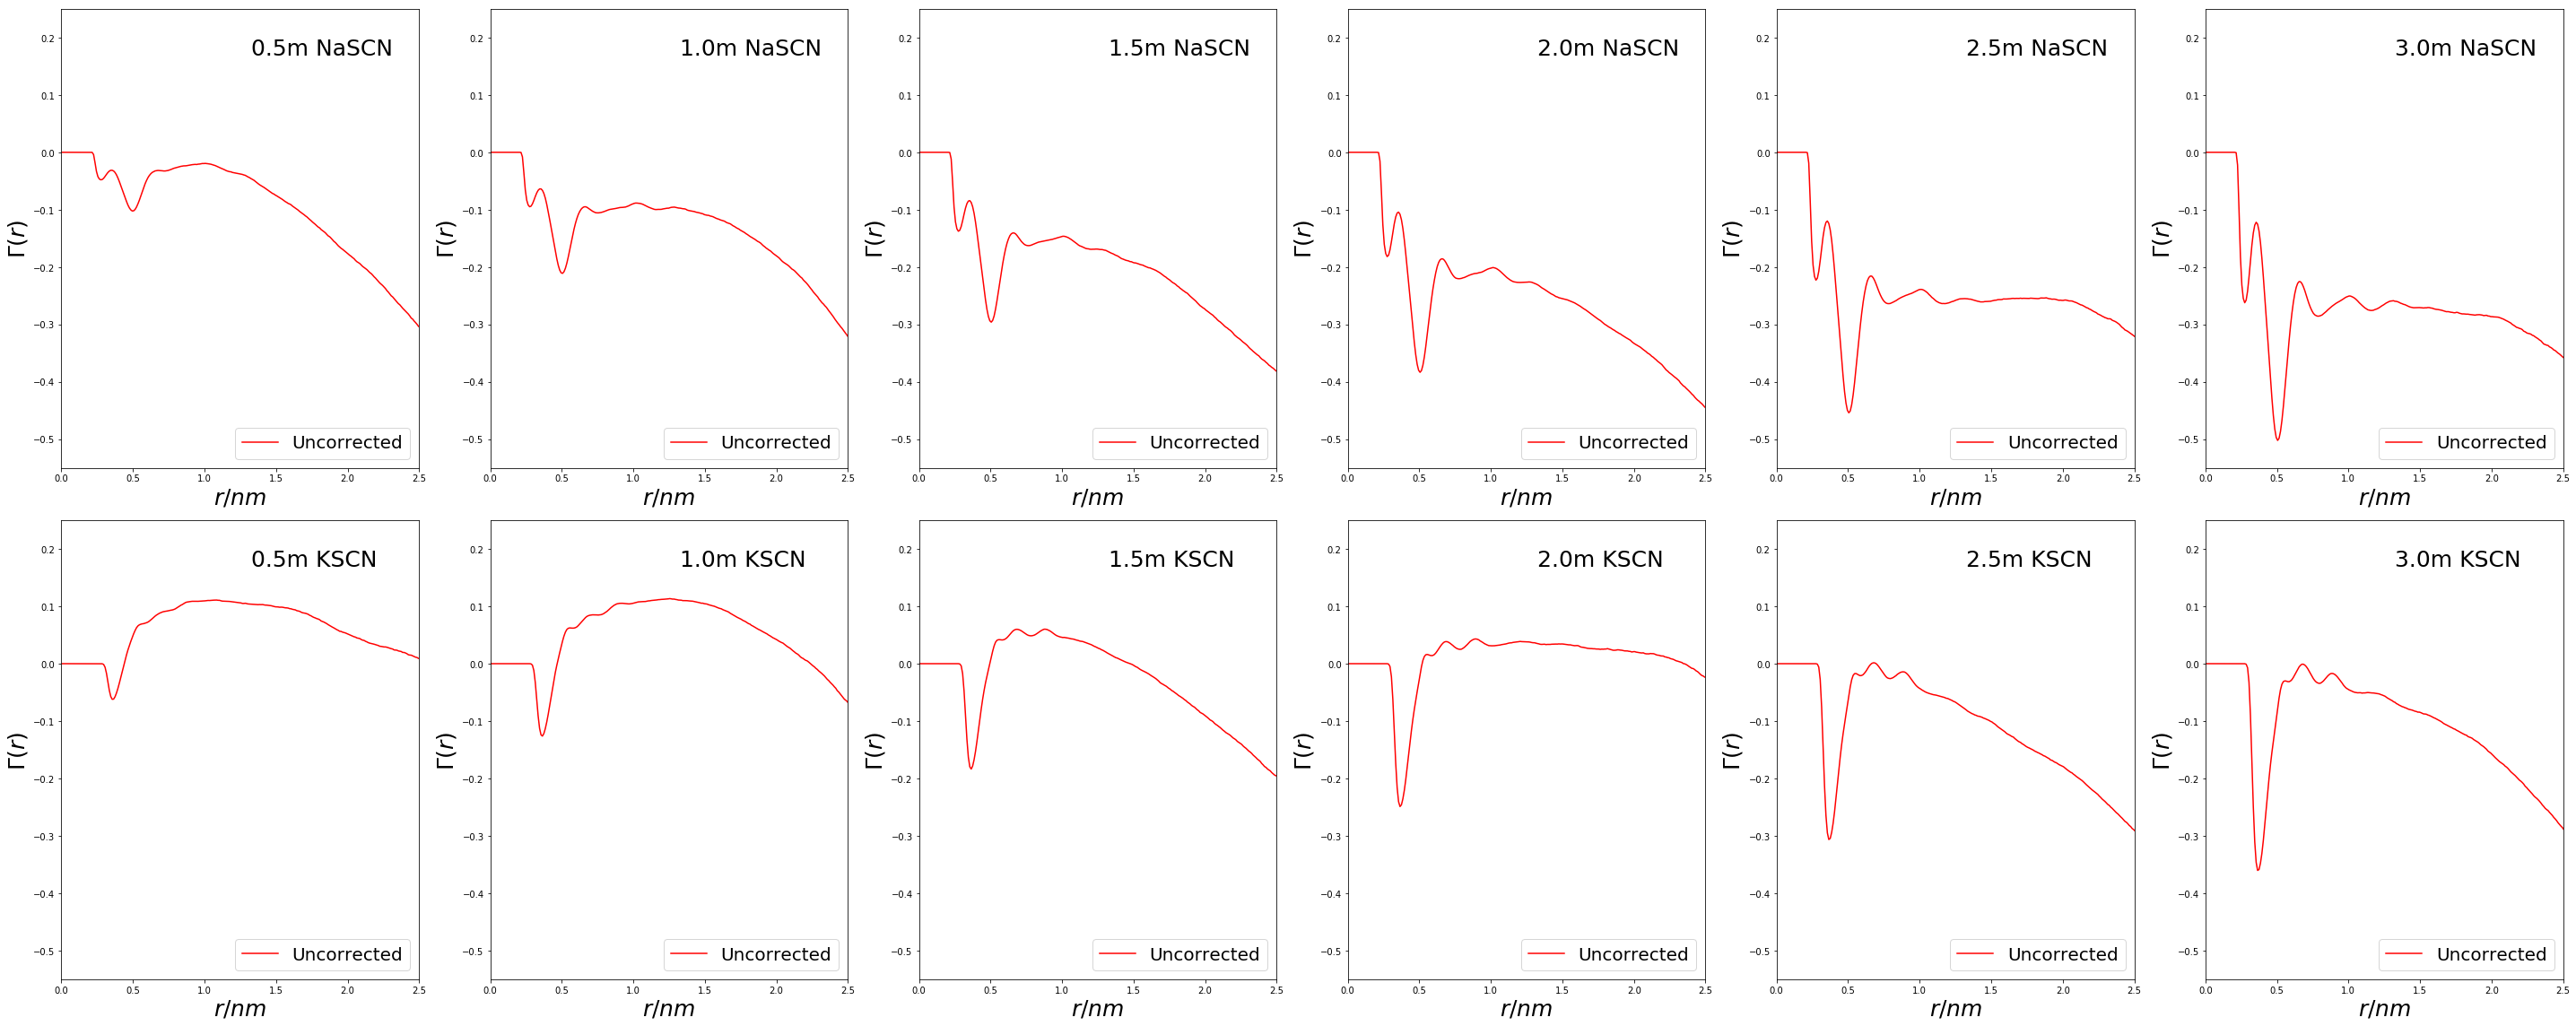

In [8]:
cations = ['Na', 'K']
anion = 'SCN'
concs = np.linspace(start=0.5, stop=3.0, num=6)

n_rows = len(cations)
n_cols = len(concs)


fig_dim = np.array((5, 2))*8
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        computeExcCoordNbrs(cations[i],anion,'spce',concs[j],ax)
        ax.annotate(str(concs[j])+'m '+cations[i]+anion,xy=(0.53,.9), fontsize=25, xycoords='axes fraction')
        plt.xlim((0, 2.5))
        plt.ylim((-0.55, 0.25))
        plt.legend(loc=4, fontsize=20)
        plt.tight_layout(w_pad=1,h_pad=1)

## Issue with finite system size
In a system of infinite volume, $\Gamma$ should converge to a fixed value. As seen above, this is not the case. The reason is that we are simulating a system of finite size, resulting in that the average concentration of ions in the system is not the same as the concentration in the solution bulk. To correct for this artifact, different correction factors can be applied. In this study, two different correction factors were employed (called Vegt and Kruger in the analysis protocol, referring to the authors of the two articles where they were found. To take one example, the Vegt correction factor is defined as

\begin{align}
g^*_{ij}(r) = g_{ij,sim}(r) \frac {N_j\left (1-\frac{V(R)}{V_{box}} \right )} {{N_j\left (1-\frac{V(R)}{V_{box}} \right )}-\Delta N_{ij}(R)-\delta _{ij}}
\tag{7}
\end{align}

Here, $N_j$ is the number of particles $j$ in the system, $V(R)$ is the volume of a sphere of radius $R$, $\Delta N_{ij}(r)$ is the excess coordination number of species $j$ around species $i$ and $\delta _{ij}$ is the Kronecker delta. The nominator in the correction factor applied represents the number of particles of species $i$ that would be present in the system at $r>R$ if the ions would be uniformly distributed throughout the volume of the simulation box. The denominator represents the actual number of ions in the system at $r>R$, based on $\Delta N_{ij}(r)$. By applying this correction the scaled RDF, $g^*_{ij}(r)$, should approach the definition of the RDF

\begin{align}
g_{ij}(r) = \frac{\rho _{ij}(r)}{\rho_{j,bulk}}
\tag{8}
\end{align}

Here, the denominator is the concentration of species j in the solution bulk, in contrast to the average concentration of the species as written before. However, since $\Delta N_{ij}(r)$ is needed which is based on the analysis of a system of finite size, the denominator in the corection factor is not exactly what it aims to be. This could be why some of the corrected RDFs does not yield entirely converged values either, as can be seen when running the next two cells.



In [9]:
def computeExcCoordNbrsCorrected(cation,anion,waterModel,conc,corrIndex,subplot):
    
    """ This function computes and plots the excess coordination numbers and takes five arguments:
    - cation: 'K' or 'Na'
    - anion: 'SCN'
    - waterModel: 'spce' or 'opc3'
    - conc - 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 (m)
    - corrIndex - i.e. correction factor: 'Vegt' or 'Kruger'
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = %pwd

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)


    index = 0 # Initializing concentration index                     
        
    wdir_exp_data = WORKDIR+'/data/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
            
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
    # In this step, the coordination numbers using the two different correction factors are calculated

    # Getting increment in array with radii 
    dr = r[1]-r[0]

    # Defining the truncation distance 
    truncInd = 100
    R = r[truncInd] # Equals 1.0 nm

    # Calculating remaining volume as a function of the radius
    Vn = 4*pi/3*r**3 / V_avg

    # Calculating the total number of ions in the box 
    N_c = rho_c_avg*V_avg

    # Calculating coordination number without correction factor
    N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
    N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
    Gamma = N_cc - N_wc

    # Calculating Vegt correction factors, corresponding rdf:s and coordination numbers, full trajectory
    if corrIndex is 'Vegt':
        corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
        corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
        g_cc_avg = g_cc_avg * corr_cc
        g_wc_avg = g_wc_avg * corr_wc
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        plotColor = 'green' 

    # Calculating coordination numbers with Krüger correction factor, full trajectory
    elif corrIndex is 'Kruger':
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
        plotColor = 'blue'

    # Calculating gamma function
    Gamma = N_cc - N_wc

    subplot.plot(r,Gamma,color=plotColor,label='Corrected ('+corrIndex+')')
    subplot.set_xlabel("$r/nm$", fontsize=25)
    subplot.set_ylabel("$\Gamma(r)$", fontsize=25)

## Plotting $\Gamma$ based on scaled RDFs
Here, $\Gamma$ is plotted for NaSCN and KSCN at all concentrations studied, with a correction factor applied to acoount for the finite size of the simulation box.

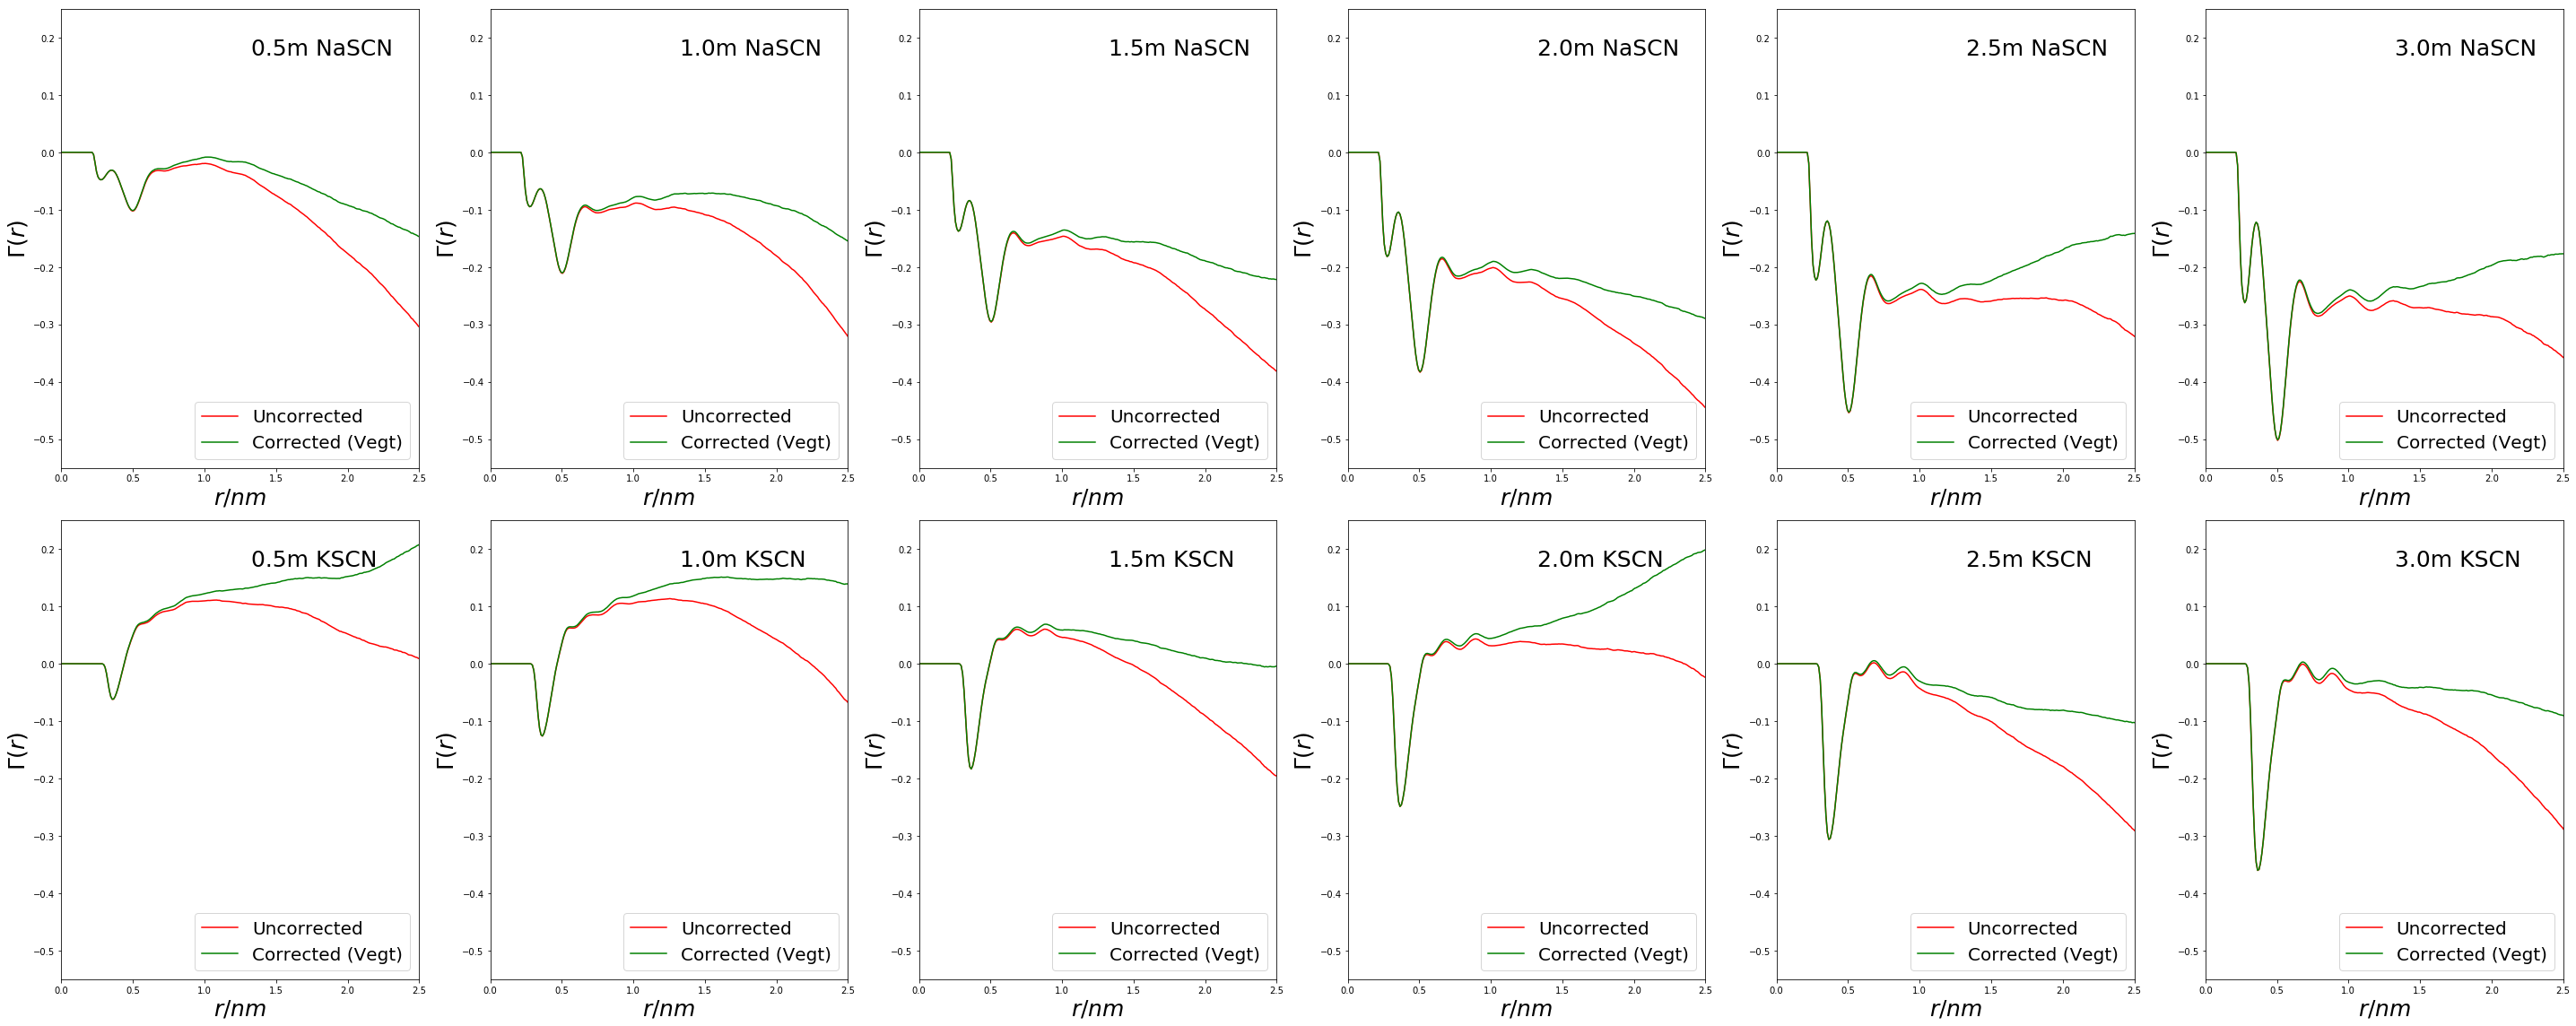

In [10]:
cations = ['Na', 'K']
anion = 'SCN'
concs = np.linspace(start=0.5, stop=3.0, num=6)

n_rows = len(cations)
n_cols = len(concs)


fig_dim = np.array((5, 2))*8
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        computeExcCoordNbrs(cations[i],anion,'spce',concs[j],ax)
        computeExcCoordNbrsCorrected(cations[i],anion,'spce',concs[j],'Vegt',ax)
        ax.annotate(str(concs[j])+'m '+cations[i]+anion,xy=(0.53,.9), fontsize=25, xycoords='axes fraction')
        plt.xlim((0, 2.5))
        plt.ylim((-0.55, 0.25))
        plt.legend(loc=4, fontsize=20)
        plt.tight_layout(w_pad=1,h_pad=1)

## Calculating the wanted property,  $a_{c}'$

In the next cell, $a_{c}'$ will be calculated according to Equation 2. 

In [11]:
def actDer(cation,anion,waterModel,corrIndex,subplot):
    
    """ This function plots activity derivatives and takes three arguments:
    - cation: 'K' or 'Na'
    - anion: 'SCN'
    - waterModel: 'spce' or 'opc3'
    - corrIndex - i.e. correction factor: 'Vegt' or 'Kruger' 
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = %pwd
    
    # Defining molar mass of water (kg/mol)
    MW_H2O = 18.01528e-3
    
    # Listing avalable molal concentrations (mol/(kg solvent))
    concs_m = np.linspace(start=0.5, stop=3.0, num=6) 

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)

    # Declaring variables that will be calculated later
    molar = np.empty([1, len(concs_m)]) # molar concentrations [mol/l]
    molal = np.empty([1, len(concs_m)]) # molal concentrations [mol/(kg solvent)]
    actDer = np.empty([len(block_range),len(concs_m)]) # activity derivatives per block
    actDerErr = np.empty([2, len(concs_m)]) # standard deviation among blocks
    actDerAvg = np.empty([1,len(concs_m)]) # activity derivative, full trajectory

    index = 0 # Initializing concentration index

    for conc_m in concs_m: # Looping over concentrations                      
        
        wdir_exp_data = WORKDIR+'/data/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
        wdir = wdir_exp_data+str(conc_m)+'m/'
        #%cd $wdir # Changing directory to dire
        #!pwd
        ind = 0 # Initializing block index

        g_cc_avg = 0 # Initializing radial distribution function of ion around ion
        g_wc_avg = 0 # Initializing radial distribution function of ion around water
        V_avg = 0 # Initializing volume of the system
        rho_c_avg = 0 # Initializing salt density of system    
        rho_w_avg = 0 # Initializing water density of system    
        
        for block in block_range: # Looping over blocks  
            
            # if pickle file exists, use that
            if os.path.isfile( wdir+'g_cc_'+str(block) ) and os.path.isfile( wdir+'g_wc_'+str(block) ):        

                #print("Loading from saved pickle")

                # Loading stored files from directory
                g_cc = np.loadtxt(wdir+'g_cc_'+str(block))
                g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
                g_wc = np.loadtxt(wdir+'g_wc_'+str(block))
                g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
                r = np.loadtxt(wdir+'r_'+str(block))
                V = np.loadtxt(wdir+'V_'+str(block))
                V_avg = V_avg + V/len(block_range) # Calculating average among blocks
                rho_c = np.loadtxt(wdir+'rho_c_'+str(block))
                rho_c_avg = rho_c_avg + rho_c/len(block_range)
                rho_w = np.loadtxt(wdir+'rho_w_'+str(block))
                rho_w_avg = rho_w_avg + rho_w/len(block_range)

            else:
                print("The necessary files are not available in the current working directory")

            # In this step, the coordination numbers using the two different correction factors are calculated

            # Defining the truncation distance 
            truncInd = 100
            R = r[truncInd] # Equals 1.0 nm
            
            # Getting increment in array with radii 
            dr = r[1]-r[0]
            
            # Calculating coordination number without correction factor
            N_cc = rho_c * 4 * pi * np.cumsum( ( g_cc - 1 ) * r ** 2 * dr )
            N_wc = rho_c * 4 * pi * np.cumsum( ( g_wc - 1 ) * r ** 2 * dr )
            Gamma = N_cc - N_wc

            # Calculating remaining volume as a function of the radius
            Vn = 4*pi/3*r**3 / V
                        
            N_c = rho_c*V
            N_w = rho_w*V    
                
            # Calculating Vegt correction factors, corresponding rdf:s and coordination numbers
            if corrIndex is 'Vegt':
                corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
                corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
                g_ccc = g_cc * corr_cc
                g_wcc = g_wc * corr_wc
                N_ccc = rho_c * 4 * pi * np.cumsum( ( g_ccc - 1 ) * r ** 2 * dr )
                N_wcc = rho_c * 4 * pi * np.cumsum( ( g_wcc - 1 ) * r ** 2 * dr )


            # Calculating coordination number with Krüger correction factor 
            elif corrIndex is 'Kruger':
                N_ccc = rho_c * 4 * pi * np.cumsum( ( g_cc - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
                N_wcc = rho_c * 4 * pi * np.cumsum( ( g_wc - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )

            # Calculating gamma function
            Gammac = N_ccc - N_wcc 

            # Obtaining value of Gamma function used to calculate the activity derivative, Vegt correction
            if corrIndex is 'Vegt':
                Gammac_plateau=Gammac[truncInd]

            # Obtaining value of Gamma function used to calculate the activity derivative, Krüger correction
            elif corrIndex is 'Kruger':
                Gammac_plateau=Gammac[2*truncInd]

            # Calculating activity derivative for the current block and concentration (ind, index)
            actDer[ind, index] = 1 / ( 1 + Gammac_plateau )

            # Increasing block index with 1
            ind = ind + 1

        # Calculating average coordination numbers without correction factor
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        Gamma_avg = N_cc - N_wc
        #np.savetxt(wdir+'excCoordSimNoCorr', Gamma_avg)

        # Calculating Vegt correction factors, corresponding rdf:s and coordination numbers, full trajectory
        if corrIndex is 'Vegt':
            corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
            corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
            g_ccc = g_cc_avg * corr_cc
            g_wcc = g_wc_avg * corr_wc
            N_ccc = rho_c_avg * 4 * pi * np.cumsum( ( g_ccc - 1 ) * r ** 2 * dr )
            N_wcc = rho_c_avg * 4 * pi * np.cumsum( ( g_wcc - 1 ) * r ** 2 * dr )

        # Calculating coordination numbers with Krüger correction factor, full trajectory
        elif corrIndex is 'Kruger':
            N_ccc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
            N_wcc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )

        # Calculating gamma function, used to calculate the activity derivative
        Gammac_avg = N_ccc - N_wcc 

        # Calculating the activity derivative for the current concentration and correction
        if corrIndex is 'Vegt':
            # Truncating the integral according to the Vegt correction
            Gammac_plateau_avg = Gammac_avg[truncInd] 
            # Obtaining the activity derivative, Vegt correction
            actDerAvg[0, index] = 1 / ( 1 + Gammac_plateau_avg ) 
        elif corrIndex is 'Kruger': 
            # Truncating the integral according to the Krüger correction
            Gammac_plateau_avg = Gammac_avg[2*truncInd] 
            # Obtaining the activity derivative, Krüger correction
            actDerAvg[0, index] = 1 / ( 1 + Gammac_plateau_avg ) 
        
        #print("Number of ions in simulation box: ", N_c)
        #print("Number of water molecules in simulation box: ", N_w)
        
        molal[0, index] = N_c/(2*N_w*MW_H2O) # Obtaining molality, based on system quantities
        
        # Obtaining the standard deviation among blocks of activity derivatives,
        actDerErr[0, index] = np.std(actDer[:, index]) 
        # where one is later plotted upwards from the mean value and the other downwards
        actDerErr[1, index] = np.std(actDer[:, index]) 

        index = index + 1 # Increasing concentration index by 1


    # Loading experimental data
    m = np.loadtxt(wdir_exp_data+'molality', delimiter=',', unpack=True)
    a = np.loadtxt(wdir_exp_data+'actDer', delimiter=',', unpack=True)
    mShort = m[0:360]
    aShort = a[0:360]

    # Labelling axes
    subplot.set_xlabel("$m$  / kg l$^{-1}$", fontsize=17)
    subplot.set_ylabel(r'$a_{c}^{\prime}$', fontsize=17)

    # Specifying color and symbol to use in the plot, depending on ion pair and correction used
    if cation is 'Na':
        ionColor = 'g'

    elif cation is 'K':
        ionColor = 'b'

    if corrIndex is 'Vegt':
        symbol = '^'

    elif corrIndex is 'Kruger':
        symbol = 's'

    # Plotting continuous experimental activity derivative curves together with simulated data points
    subplot.plot(mShort, aShort, color=ionColor, lw=2, label='experiments, '+cation+'$^+$')
    subplot.errorbar(molal[0,:], actDerAvg[0,:], actDerErr[:,:], fmt=ionColor+symbol,ms=8, 
                     markeredgecolor=ionColor,label='simulations, '+cation+'$^+$', alpha=0.6, mew=2, elinewidth=2,capsize=5)
                 #label=cation+'$^+$, '+corrIndex, alpha=.6, mew=2, elinewidth=2,capsize=5)

    subplot.set_xlim((0, 3.5))
    subplot.set_ylim((0.8, 2.0))

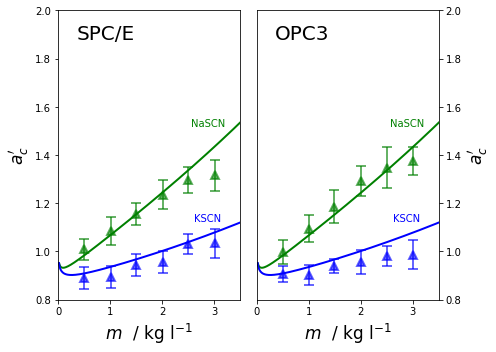

In [12]:
waterModels = ['spce', 'opc3']
annotations = ['SPC/E', 'OPC3']

fig_dim = np.array((3.5, 2.5))*2
fig = plt.figure(figsize=fig_dim)

for i in range(len(waterModels)):
    ax = fig.add_subplot(1,len(waterModels),i+1)
    actDer('Na','SCN',waterModels[i],'Vegt',ax)
    actDer('K','SCN',waterModels[i],'Vegt',ax)
    ax.set_xticks([0,1,2,3])
    if i == 0:
        ax.yaxis.set_label_position("left")
        
    else:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        
    ax.annotate(annotations[i],xy=(.1,.9), fontsize=20, xycoords='axes fraction')
    ax.annotate('NaSCN',xy=(.73,.6), fontsize=10, xycoords='axes fraction', color='green')
    ax.annotate('KSCN',xy=(.75,.27), fontsize=10, xycoords='axes fraction', color='blue')

    plt.tight_layout(w_pad=1,h_pad=1)
    
    plt.savefig('figs/actderSI.pdf')

## Activity derivative ($a_{c}'$) plots

Above the property $a_{c}'$ is plotted for NaSCN and KSCN, using two different water models: SPC/E and OPC3. The symbols represent the simulated data (the van der Vegt and Krüger correction factors appear as triangles and squares, respectively).The lines represent experimental data. As can be seen the forcefield developed in this study produces activity derivatives close to experimental data for both water models. 

Author: Vidar Aspelin